In [3]:
import foolbox as fb
import torch
import torchvision
import numpy as np
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()
with open("imagenet_labels.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using cache found in C:\Users\tonyyyyy/.cache\torch\hub\pytorch_vision_v0.10.0


In [4]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [95]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# read in the image files from different folders and each folder corresponds to a label
top = "adv/"
index = 0

data = []
label = []

for root, dirs, files in os.walk(top, topdown=False):
    for name in dirs:
        temp = os.path.join(root, name)
        for root1, dirs1, files1 in os.walk(temp, topdown=False):
            for j in files1:
                img_name = os.path.join(root1, j)
                img = image.load_img(img_name)
                data.append(img)
                label.append(int(name))
        print(name)

291
292
331
340
366
388
99


In [96]:
pred= []
for i in data:
  input_tensor = preprocess(i)
  input_batch = input_tensor.unsqueeze(0)
  input_batch = torch.round(input_batch, decimals=1)
  feature = model(input_batch)

  probabilities = torch.nn.functional.softmax(feature[0], dim=0)
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  pred.append(top5_catid[0])

In [69]:
couunt = 0
index = []
for i in range(len(pred)):
    if (label[i] == pred[i].int()):
        index.append(i)
        couunt+=1

In [70]:
couunt

146

In [71]:
len(pred)

154

In [60]:
#make prediction on the original image files and see how many can be correctly classified
pred= []
for i in data:
  input_tensor = preprocess(i)
  input_batch = input_tensor.unsqueeze(0)
  feature = model(input_batch)
  probabilities = torch.nn.functional.softmax(feature[0], dim=0)
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  pred.append(top5_catid[0])

In [61]:
#filter out the images correctly classified
index = []
for i in range(len(pred)):
    if (label[i] == pred[i].int()):
        index.append(i)

In [72]:
data = np.array(data)
data = data[index]
label = np.array(label)
label = label[index]

C:\Users\tonyyyyy\AppData\Local\Temp/ipykernel_3060/3545812721.py:1: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data = np.array(data)
C:\Users\tonyyyyy\AppData\Local\Temp/ipykernel_3060/3545812721.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [73]:
#!/usr/bin/env python3
"""
A simple example that demonstrates how to run a single attack against
a PyTorch ResNet-18 model for different epsilons and how to then report
the robust accuracy.
"""
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD

In [74]:
label = torch.tensor(label)

In [75]:
label

tensor([291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291, 291,
        291, 291, 291, 291, 291, 291, 291, 292, 292, 292, 292, 292, 292, 292,
        292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292,
        292, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331,
        331, 331, 331, 331, 331, 331, 331, 331, 340, 340, 340, 340, 340, 340,
        340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340,
        340, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366,
        366, 366, 366, 366, 366, 366, 366, 366, 366, 388, 388, 388, 388, 388,
        388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99], dtype=torch.int32)

In [43]:
pre = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [44]:
outputs = []

for i in (data):
    tensor =  pre(i)   #transform from (64, 1, 224, 224) to (64, 32, 224, 224)
    outputs.append(tensor[None, :])

result = torch.cat(outputs, dim=0)  #shape (64, 32*in_channels, 224, 224)

In [45]:
#model = models.resnet18(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

clean_acc = accuracy(fmodel, result, label)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")
attack = LinfPGD()



clean accuracy:  100.0 %


In [46]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.1)

This is the 4 iteration
Generating adversarial image based on current model
Array of original pictures, difference between original and adversrial, Adversarial images


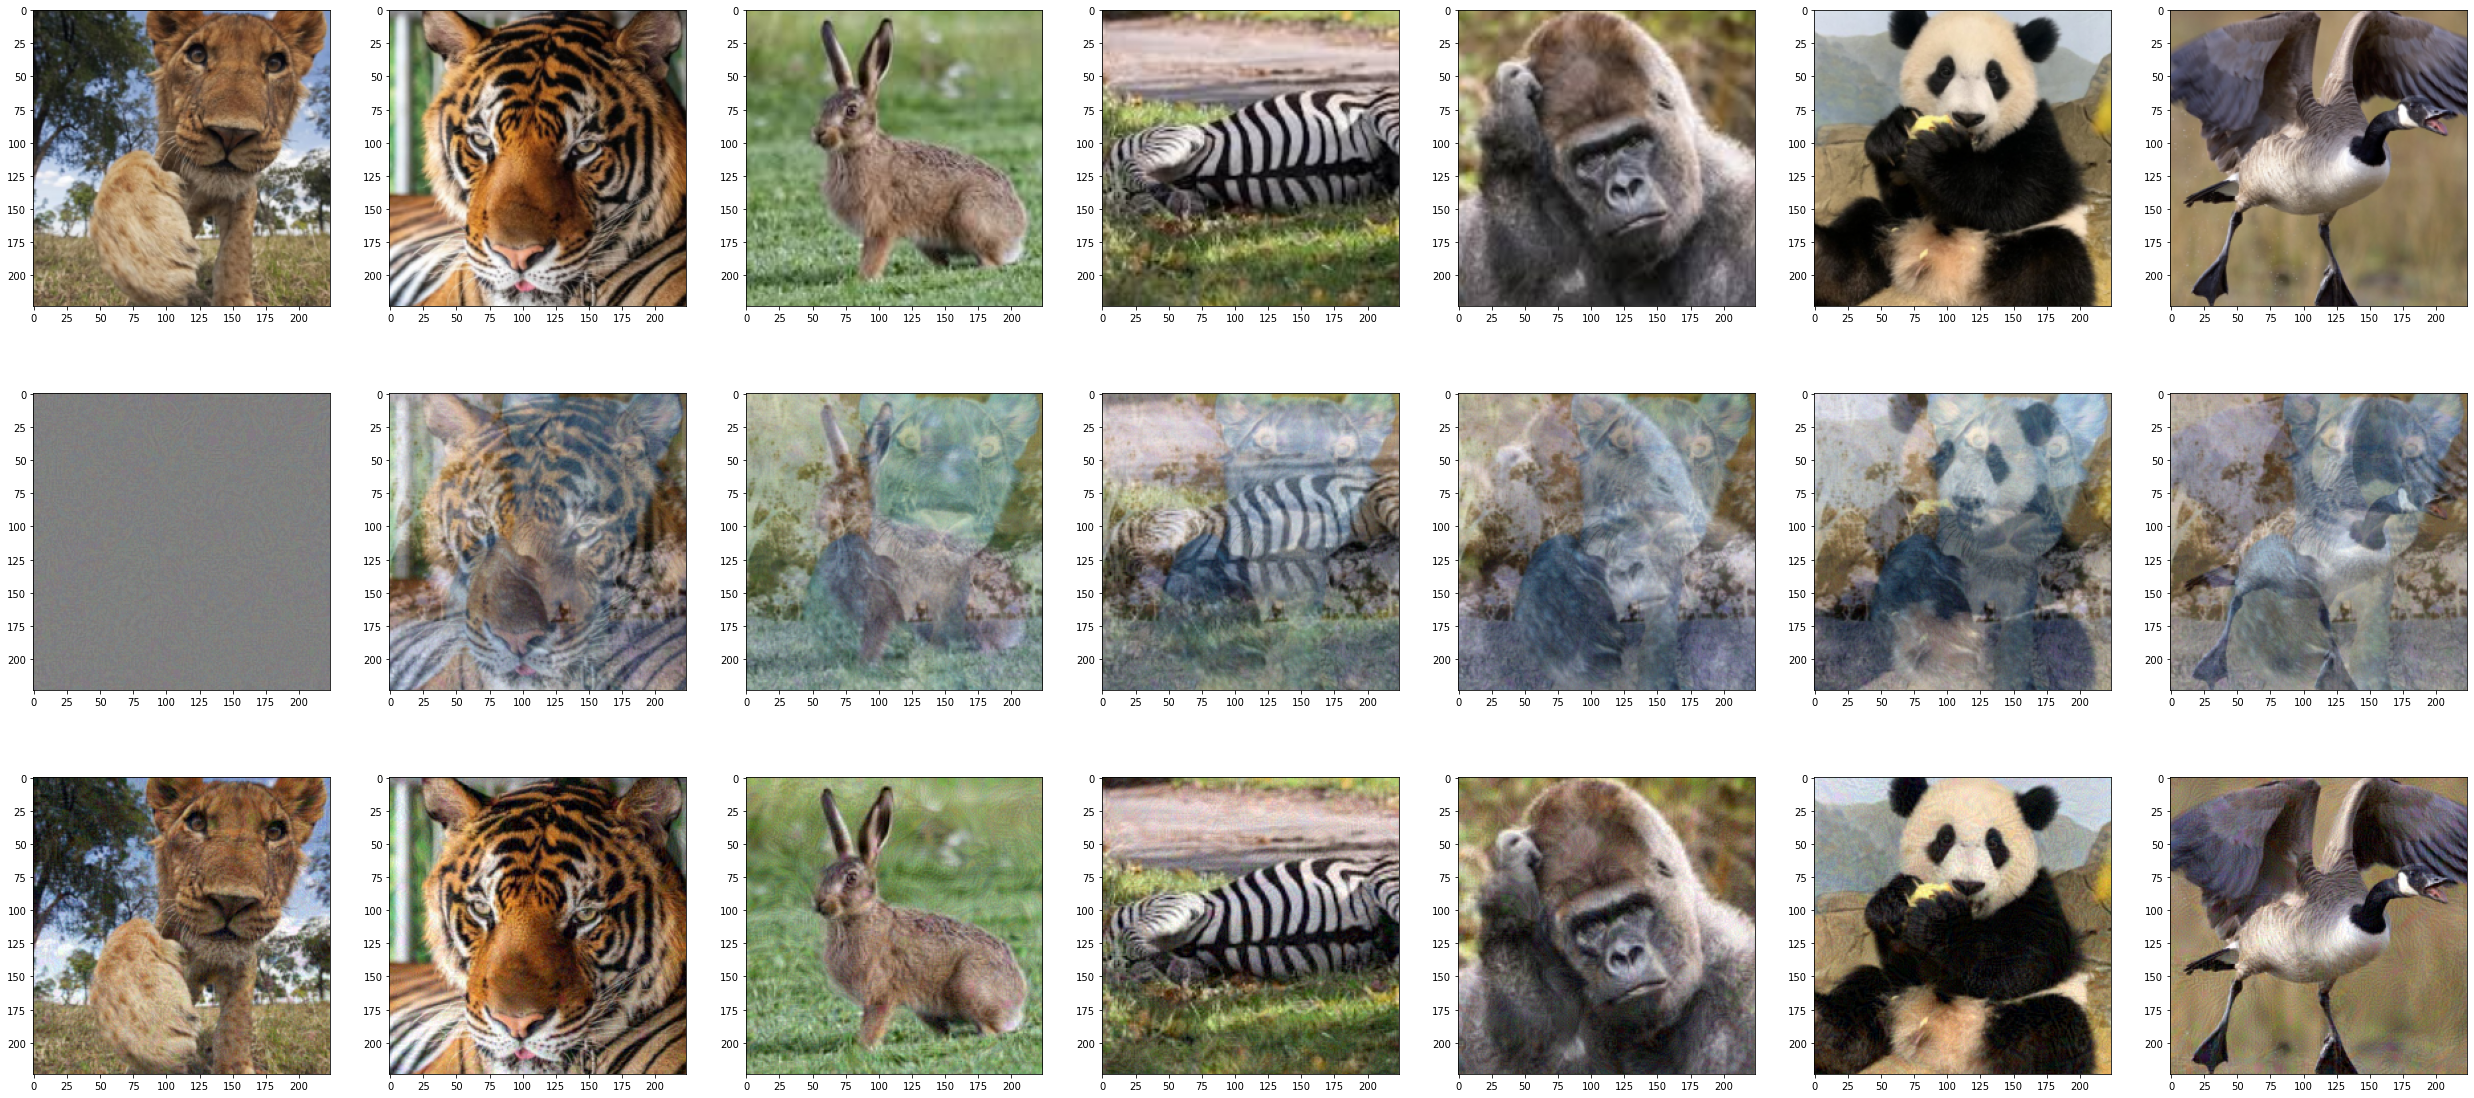

How effective are the adversrial images: 
For 0.0 item shown in picture array it's predicted to be: 
lynx
It's true label is: 
lion
For 1.0 item shown in picture array it's predicted to be: 
jaguar
It's true label is: 
tiger
For 2.0 item shown in picture array it's predicted to be: 
wood rabbit
It's true label is: 
hare
For 3.0 item shown in picture array it's predicted to be: 
tiger
It's true label is: 
zebra
For 4.0 item shown in picture array it's predicted to be: 
chambered nautilus
It's true label is: 
gorilla
For 5.0 item shown in picture array it's predicted to be: 
king snake
It's true label is: 
giant panda
For 6.0 item shown in picture array it's predicted to be: 
chickadee
It's true label is: 
goose
The fraction of mislabeled image is: 
0.9694656488549618
retrain the network with adversrial image and right label
13.35609245300293
10.382824897766113
8.08830738067627
6.455962181091309
5.305201530456543
clean accuracy:  96.9 %
End of 4 iteration
This is the 5 iteration
Generati

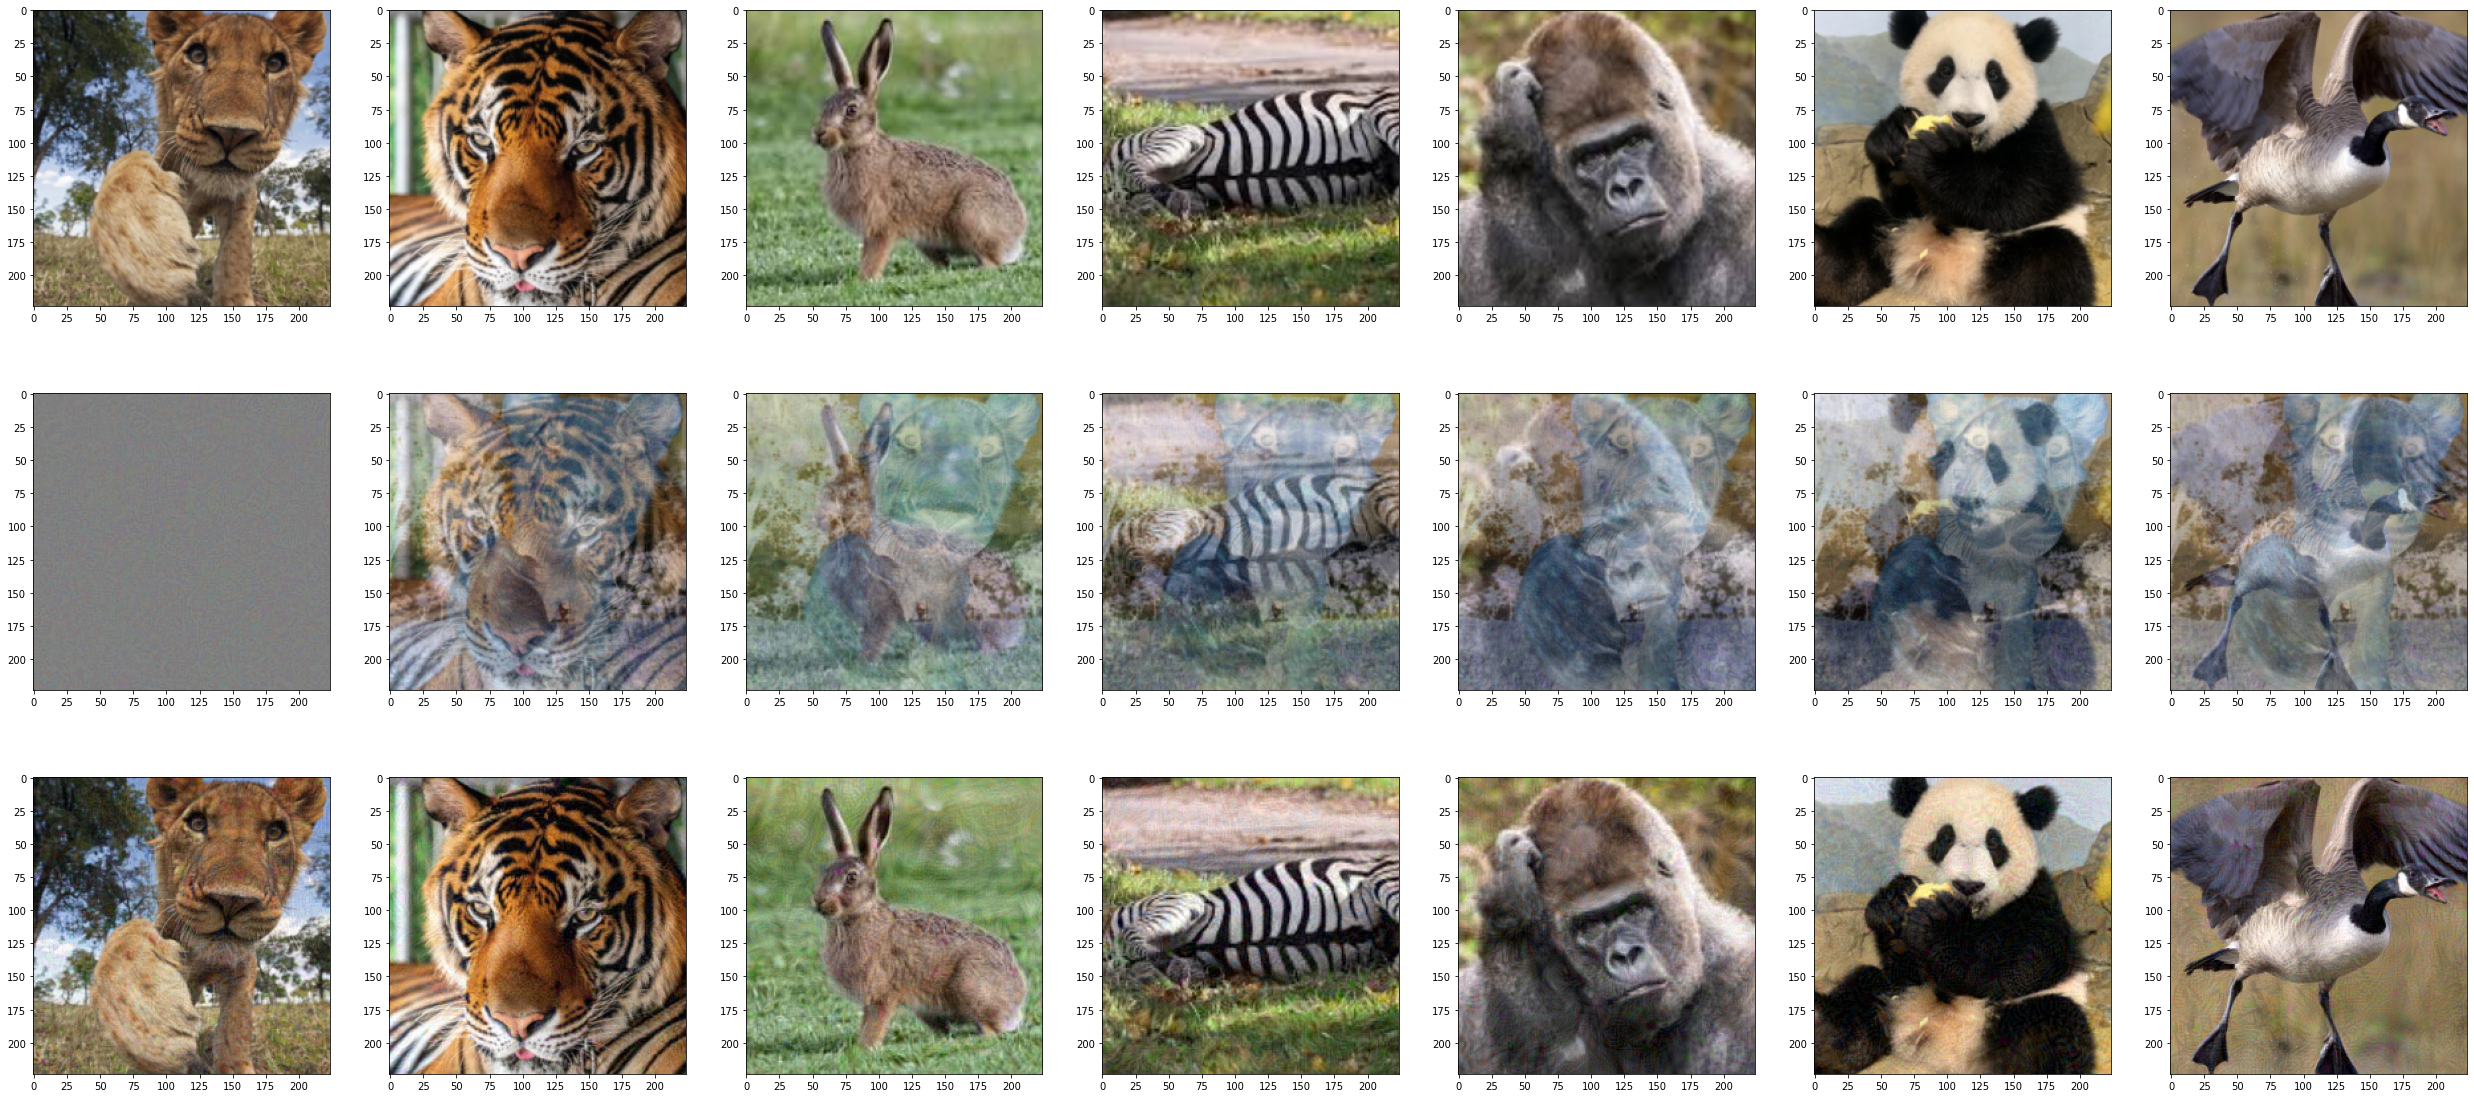

How effective are the adversrial images: 
For 0.0 item shown in picture array it's predicted to be: 
trilobite
It's true label is: 
lion
For 1.0 item shown in picture array it's predicted to be: 
tiger
It's true label is: 
tiger
For 2.0 item shown in picture array it's predicted to be: 
hare
It's true label is: 
hare
For 3.0 item shown in picture array it's predicted to be: 
zebra
It's true label is: 
zebra
For 4.0 item shown in picture array it's predicted to be: 
bustard
It's true label is: 
gorilla
For 5.0 item shown in picture array it's predicted to be: 
Gila monster
It's true label is: 
giant panda
For 6.0 item shown in picture array it's predicted to be: 
quill
It's true label is: 
goose
The fraction of mislabeled image is: 
0.8091603053435115
retrain the network with adversrial image and right label
5.382748603820801
4.621212959289551
4.085643291473389
3.6656553745269775
3.320767402648926
clean accuracy:  96.2 %
End of 5 iteration


In [29]:
import matplotlib.pyplot as plt

for loop in range(4,6):
    print("This is the " + str(loop) + " iteration")
    print("Generating adversarial image based on current model")
    raw_advs, clipped_advs, success = attack(fmodel, result, label.long(), epsilons=0.05)

    #print(fb.plot.images(images = clipped_advs[[0,20,40,60,80,100,120,140]]))
    tmp = (result - clipped_advs[0])
    tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
    #print(fb.plot.images(images=tmp[[0, 20, 40, 60, 80, 100, 120, 140]]))
    fig = plt.figure(figsize=(50, 20))  # width, height in inches

    print("Array of original pictures, difference between original and adversrial, Adversarial images")
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        sub = fig.add_subplot(3, 8, i+1)
        sub.imshow(result[i*20].permute(1, 2, 0))
        sub = fig.add_subplot(3, 8, 9+i)
        sub.imshow(tmp[i*20].permute(1, 2, 0))
        sub = fig.add_subplot(3, 8, 17+i)
        sub.imshow(clipped_advs[i*20].permute(1, 2, 0))
    plt.show()

    print("How effective are the adversrial images: ")
    count = 0
    iter = []
    for i in range(len(clipped_advs)):
      input_tensor = clipped_advs[i]
      input_batch = input_tensor.unsqueeze(0)
      iter.append(input_batch)
      feature = model(input_batch)
      probabilities = torch.nn.functional.softmax(feature[0], dim=0)
      top_prob, top_catid = torch.topk(probabilities, 1)
      id = label[i]
      if (id != top_catid):
          count = count + 1
      if(i%20 ==0):
          print("For " + str(i/20) + " item shown in picture array it's predicted to be: ")
          print(categories[top_catid[0]])
          print("It's true label is: ")
          print(categories[label[i]])
    print("The fraction of mislabeled image is: ")
    print(count/len(label))
    iter = torch.cat(iter, dim=0)
    print("retrain the network with adversrial image and right label")
    for epoch in range(5):  # loop over the dataset multiple times
        running_loss = 0.0
        optimizer.zero_grad()
        outputs = model(iter)
        loss = criterion(outputs, label.long())
        loss.backward()
        optimizer.step()
        print(loss.item())
    fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)
    attack = LinfPGD()
    clean_acc = accuracy(fmodel, result, label)
    print(f"clean accuracy:  {clean_acc * 100:.1f} %")
    print("End of " + str(loop) + " iteration")

In [102]:
pre = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
outputs = []

for i in (data):
    tensor = pre(i)  #transform from (64, 1, 224, 224) to (64, 32, 224, 224)
    outputs.append(tensor[None, :])

result = torch.cat(outputs, dim=0)  #shape (64, 32*in_channels, 224, 224)
#model = models.resnet18(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

clean_acc = accuracy(fmodel, result, label)

In [107]:
len(result)

138

In [132]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Using cache found in C:\Users\tonyyyyy/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [145]:
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)
attack = LinfPGD()

In [146]:
import matplotlib.pyplot as plt
raw_advs, clipped_advs, success = attack(fmodel, result, label.long(), epsilons=0.05)




In [147]:
iter = []

count = 0
for i in range(len(clipped_advs)):
    input_tensor = clipped_advs[i]
    input_batch = input_tensor.unsqueeze(0)
    input_batch = input_batch*2
    input_batch = torch.round(input_batch)
    input_batch = input_batch/2
    iter.append(input_batch)
    feature = model(input_batch)
    probabilities = torch.nn.functional.softmax(feature[0], dim=0)
    top_prob, top_catid = torch.topk(probabilities, 1)
    id = label[i]
    if (id == top_catid):
        count = count + 1
print("The fraction correctly labeled image is: ")
print(count/len(label))

The fraction correctly labeled image is: 
0.9347826086956522


In [139]:
iter = torch.cat(iter, dim=0)


In [140]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

In [142]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    optimizer.zero_grad()
    outputs = model(iter)
    loss = criterion(outputs, label.long())
    loss.backward()
    optimizer.step()
    print(loss.item())

0.1936422735452652
0.16596205532550812


In [143]:
clean_acc = accuracy(fmodel, result, label)

In [144]:
clean_acc

1.0